# imgAna_OpenCV * snap for home....



In [ ]:
#!pip install opencv-contrib-python

Getting this running locally
```bash
pip install opencv-contrib-python
pip install pandas
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
pip install beautifulsoup4
pip install Pillow
```

### Phase I:
- **explore**
- develop
- push 
- production

In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import json
import datetime 

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout

from bs4 import BeautifulSoup

%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from  functools import lru_cache
import requests

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

import time
from PIL import Image,  ImageDraw  # https://pillow.readthedocs.io/en/4.3.x/
import io
import base64


In [2]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

## Process a local file

<class 'numpy.ndarray'>
(240, 362, 3)


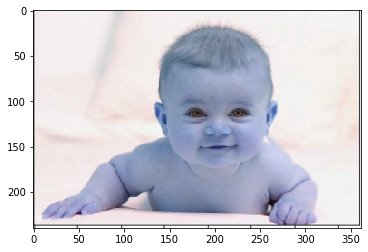

In [3]:
#img_raw = cv2.imread('../facialLocation.jpg')
img_raw = cv2.imread('../datasets/baby1.png')
print(type(img_raw))
print(img_raw.shape)
plt.imshow(img_raw)

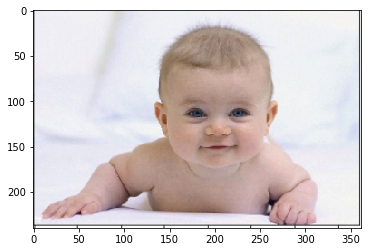

In [4]:
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

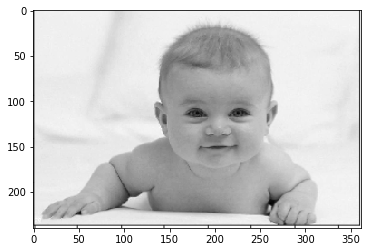

In [5]:
#Converting to grayscale
img_bw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

# Displaying the grayscale image
plt.imshow(img_bw, cmap='gray')

### Phase II:
- explore
- **develop**
- push 
- production


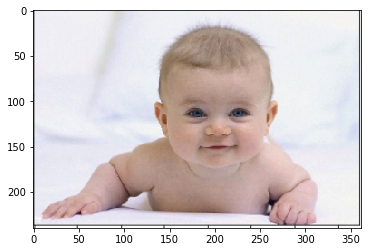

In [6]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(convertToRGB(img_raw))

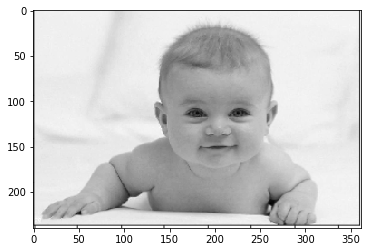

In [7]:
def convertToBW(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(convertToBW(img_raw), cmap='gray')

In [8]:
haar_cascade_face = cv2.CascadeClassifier('../datasets/haarcascade_frontalface_default.xml')
haar_cascade_face

<CascadeClassifier 0x11da66b10>

In [9]:
faces_rects = haar_cascade_face.detectMultiScale(img_bw, scaleFactor = 1.2, minNeighbors = 5);

# Let us print the no. of faces found
print("Faces found: {} faces within regions:{}".format(len(faces_rects), faces_rects))


Faces found: 1 faces within regions:[[138  56 140 140]]


[[144  60 129 129]]


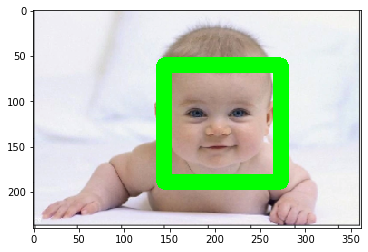

In [10]:
def detect_faces(image, cascade, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = convertToBW(image_copy)

    # Applying the haar classifier to detect faces
    image_rects = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    return image_rects

def rects_render(image, rects):
    image_copy = image.copy()
    for (x, y, w, h) in rects:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 15)
    return image_copy
    
img_raw = cv2.imread('../datasets/baby1.png')
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
if len(rects)> 0:
    img_rects = rects_render(img_rgb, rects)
    print(rects)
    plt.imshow(img_rects)
else:
    print("On image")

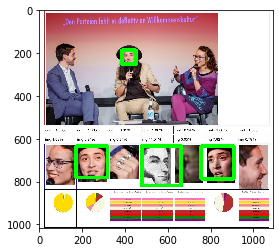

In [11]:
img_raw = cv2.imread('../datasets/imgClassify.jpg')
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
img_rects = rects_render(img_rgb, rects)
plt.imshow(img_rects)

# Fetch a image from the web
Problem - 

The image that gets processed is not the same image that is sent which makes the face region wrong. 
Notes:
- [x] do not want to send images from streams
- [x] Streams will the image, render gets image
- [x] region overlays on image that is fetched.
[x] get the face detection to work on the exact original image
[-]work out the proportion between the computed image region and the original


Use the the URLs for testing.

In [15]:
# Get and image from the web. 
urls = ["https://upload.wikimedia.org/wikipedia/commons/1/1e/Christopher_de_Paus.JPG",
       "https://upload.wikimedia.org/wikipedia/commons/a/a5/Anne_Bethel_Spencer_in_her_wedding_dress.jpg",
       "https://upload.wikimedia.org/wikipedia/commons/f/f7/Barbara_Anderson_1969.JPG"]
response = requests.get(urls[0])

### OpenCV locate face region : face_rects
- OpenCV to fetch process image, locate the faces.
- OpenCV to render the results.

This processing will be pushed to Streams.


#### face_rects[] is a list of retanges that the face is in

/Users/siegenth/anaconda2/envs/JupyterDev/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


Size of image to process :  (2465, 1431, 3)
Found: 4 potential faces. 
 [[ 136   91   51   51]
 [ 473  264  306  306]
 [ 586  890  100  100]
 [ 915 1711  160  160]]


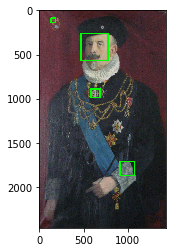

In [16]:
def bts_to_img(bts):
    '''
    :param bts: results from image_to_bts
    '''
    buff = np.fromstring(bts, np.uint8)
    buff = buff.reshape(1, -1)
    img = cv2.imdecode(buff, cv2.IMREAD_COLOR)
    return img

img_raw = bts_to_img(response.content)
print("Size of image to process : ",img_raw.shape)
img_rgb = convertToRGB(img_raw)
face_rects = detect_faces(img_rgb, haar_cascade_face)
print("Found: {} potential faces. \n {}".format(len(face_rects),  face_rects))
img_rects = rects_render(img_rgb, face_rects)
plt.imshow(img_rects)

## Render with face_rects[] - without OpenCV crutch
Using image from web add the rects. 

- Render in a widget, in a browser. 
- Streams provides the region of the page. 



In [17]:

def line_box(ele):
    (x,y,w,h)=ele
    return (x,y, x+w,y, x+w,y+h, x,y+w, x,y)
    


def inscribe_rect(bin_image, detection_box):
    """Inscribe box on image
    
    This is updating the image passed in.
    
    Args:
        bin_image : binary image
        detection_box : region to put box around
    Return:
        return image - 
    """
    draw = ImageDraw.Draw(bin_image) 
    box_width = 5 
    draw.line(line_box(detection_box), fill="yellow", width=box_width)
    #draw.rectangle(detection_box, fill=128)
    return bin_image
   

def encode_img(img):
    """must be easier way"""
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        contents = output.getvalue() 
    return base64.b64encode(contents).decode('ascii')

def decode_img(bin64):
    """must be easier way"""
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    return img

def resize_image(bin_image, basewidth=None, baseheight=None):
    """Resize image proportional to the base, make it fit in cell"""
    if basewidth is not None:
        wpercent = (basewidth/float(bin_image.size[0]))
        hsize = int((float(bin_image.size[1])*float(wpercent)))
        return bin_image.resize((basewidth,hsize), Image.ANTIALIAS)
    wpercent = (baseheight/float(bin_image.size[1]))
    wsize = int((float(bin_image.size[0])*float(wpercent)))
    return bin_image.resize((wsize,baseheight), Image.ANTIALIAS)


## Widget to display image
demo_widget = widgets.Output(layout={'border': '1px solid green'})
display(demo_widget)

with Image.open(io.BytesIO(response.content)) as bin_image:
    for rect in face_rects:
        inscribe_rect(bin_image, rect)
    with demo_widget:
        display(bin_image)
        clear_output(wait=True)


Output(layout=Layout(border='1px solid green'))

## Get images from Wiki via Streams

We'll do the processing on the Streams, results will be send back. Below were going 
the processing in the browser to work out the processing to do. 

The model explore/develop/push/poduction, develop in the notbook

### Phase III:
- explore
- develop
- **push** 
- production


In [ ]:
from icpd_core import icpd_util
cfg=icpd_util.get_service_instance_details(name='zen-sample-icp1-blitz-env')
def get_instance():
    """Setup to access your Streams instance.

    ..note::The notebook is work within Cloud and ICP4D. 
            Refer to the 'Setup' cells above.              
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
    """
    try:
        from icpd_core import icpd_util
        import urllib3
        global cfg
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        cfg = None
        print("Outside ICP4D")
        import credential  
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', 
                                               vcap_services=credential.vcap_conf)
        instance = sc.get_instances()[0]
    return instance,cfg

instance,cfg = get_instance()

In [ ]:

## Setup the Dashboard - display images sent to Wikipedia 
##                         Next cell populates the 'Dashboard'.....
status_widget = widgets.Label(value="Status", layout={'border': '1px solid green','width':'30%'})
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'100%'})
image_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'200pt'})
rect_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'200pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid green','width':'30%'})
dashboard = widgets.VBox([status_widget, image_widget, rect_widget, title_widget, url_widget])
display(dashboard)

In [ ]:
# Notebook support
# setup 
_view = instance.get_views(name="soupActive")[0]
_view.start_data_fetch()

@catchInterrupt
def server_soup(count=25):
    """Fetch and display images from view.
    Args::
        count: number of iterations to fetch images, count<0
        is infinite
    """
    while count != 0:
        count -= 1
        view_tuples = _view.fetch_tuples(max_tuples=100, timeout=2)
        for soup_tuple in view_tuples:
            status_widget.value = soup_tuple['title']
            display_image(soup_tuple, image_region=image_widget, rect_region=rect_widget, title_region=title_widget, url_region=url_widget)

server_soup()

In [ ]:
rects = detect_faces(img_rgb, haar_cascade_face)


img_raw = bts_to_img(IMAGE)
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
print("len:", len(rects))
if len(rects) is not 0:
    img_rects = rects_render(img_rgb, rects)


stage = widgets.Output(layout={'border': '1px solid green'})
with rect_widget:
                stage.append_display_data(widgets.Image(
                    value=img_rgb,
                    #format='jpg',
                    width=300,
                    height=400,
                ))

In [ ]:
type(img_rgb)

In [ ]:
img_raw = bts_to_img(IMAGE)
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
img_rects = rects_render(img_rgb, rects)
plt.imshow(img_rects)

Phase :
- explore
- develop
- push 
- **production**

TBD